In [ ]:
!pip install lifelines

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [ ]:
# Load data and exclude empty columns
clin_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_clinical_core.txt', sep='\t', index_col=0).iloc[:, :-2] # Exclude performance_score column
ge_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_mRNA_core.txt', sep='\t', index_col=0).iloc[:, :-1]
cna_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_CNV_core.txt', sep='\t', index_col=0).iloc[:, :-1]
sur_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_OS_core.txt', sep='\t', index_col=0).iloc[:, :-1]
test_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_test_sample_list.txt', sep='\t', header=None)
train_data = pd.read_csv('/content/drive/MyDrive/bioinformatics & genomics/Project_02/GBM_train_sample_list.txt', sep='\t', header=None)

# Drop columns with any NaN values
ge_data = ge_data.dropna(axis=1)

In [ ]:
#check if the 4 files have exactly the same feature ID
clin_data.index.equals(ge_data.index) and ge_data.index.equals(cna_data.index) and cna_data.index.equals(sur_data.index)

True

# `Survival ~ Clinical`

In [ ]:
# Merge data based on the 'feature' index column
clin_sur = clin_data.join(sur_data, how='inner')

# Convert categorical data to numeric
clin_sur['gender'] = clin_sur['gender'].astype('category').cat.codes  # Convert gender to numerical codes

#c-index data frame for trained and tested dataset
c_index_train1 = []
c_index_test1 = []

#iterate the entire dataset
for i in range(train_data.shape[1]):
  #Split clinical data into train and test sets
  train_sample = clin_sur[clin_sur.index.isin(train_data[i].values)]
  test_sample = clin_sur[clin_sur.index.isin(test_data[i].values)]

  # Fit the Cox Proportional Hazards model using the training data
  cox1 = CoxPHFitter()
  cox1.fit(train_sample, duration_col='OS_OS', event_col='OS_vital_status')
  #cox1.check_assumptions(train_sample)

  #calculate and store c-index for trained and tested data.
  c_index_train = concordance_index(train_sample['OS_OS'], -cox1.predict_partial_hazard(train_sample), train_sample['OS_vital_status'])
  c_index_test = concordance_index(test_sample['OS_OS'], -cox1.predict_partial_hazard(test_sample), test_sample['OS_vital_status'])

  # Append the C-index to the lists
  c_index_train1.append(c_index_train)
  c_index_test1.append(c_index_test)

# Convert the lists of C-index values to NumPy arrays
clinical_c_index_train = np.array(c_index_train1)
clinical_c_index_test = np.array(c_index_test1)

Text(0.5, 0, '')

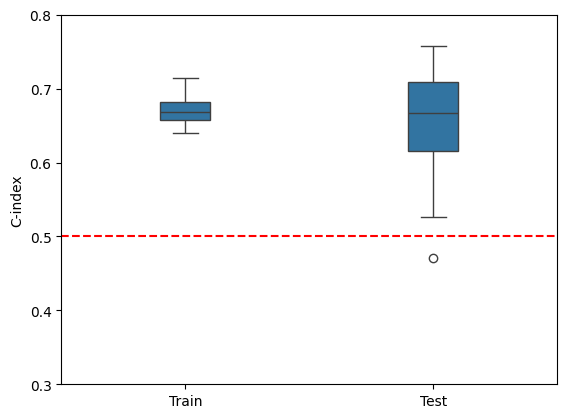

In [ ]:
# Create a DataFrame with the C-index values and set labels
c_index_data = pd.DataFrame({
    "C-index": c_index_train1 + c_index_test1,
    "Set": ["Train"] * len(c_index_train1) + ["Test"] * len(c_index_test1)
})

# Plot the C-index values
sns.boxplot(data=c_index_data, x="Set", y="C-index", width=0.2)
plt.yticks(np.linspace(0.3, 0.8, 6), labels=np.linspace(0.3, 0.8, 6).round(1))
plt.axhline(0.5, linestyle='dashed', color='red')
plt.xlabel("")

### Survival ~ CNA

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
<ipython-input-9-1273804e10c4>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cnv_c_index_data, x="Set", y="C-index", width=0.1, palette={"Train": "skyblue", "Test": "pink"})


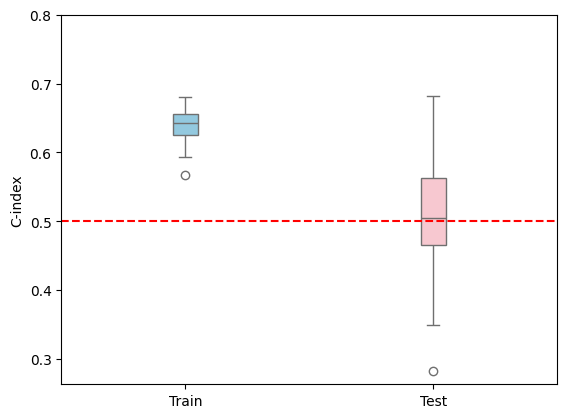

In [ ]:
# Handle CNV data similarly with Lasso regularization for feature selection
os_cnv = cna_data.join(sur_data, how='inner')

# Initialize lists for storing C-index values for CNV data
cnv_c_index_train = []
cnv_c_index_test = []

# Iterate over the entire dataset for bootstrapping and validation
for i in range(train_data.shape[1]):
    # Split CNV data into train and test sets
    train_sample = os_cnv[os_cnv.index.isin(train_data[i].values)]
    test_sample = os_cnv[os_cnv.index.isin(test_data[i].values)]

    # Fit the Cox Proportional Hazards model using the training data with Lasso regularization
    cphm = CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample, duration_col='OS_OS', event_col='OS_vital_status')

    # Calculate and store C-index for trained and tested data
    c_index_train = cphm.concordance_index_
    c_index_test = concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status'])

    # Append the C-index to the lists
    cnv_c_index_train.append(c_index_train)
    cnv_c_index_test.append(c_index_test)

# Convert the lists of C-index values to NumPy arrays
cnv_c_index_train = np.array(cnv_c_index_train)
cnv_c_index_test = np.array(cnv_c_index_test)

# Create a DataFrame with the C-index values and set labels
cnv_c_index_data = pd.DataFrame({
    "C-index": np.concatenate((cnv_c_index_train, cnv_c_index_test)),
    "Set": ["Train"] * len(cnv_c_index_train) + ["Test"] * len(cnv_c_index_test)
})

# Plot the C-index values for CNV data
sns.boxplot(data=cnv_c_index_data, x="Set", y="C-index", width=0.1, palette={"Train": "skyblue", "Test": "pink"})
plt.yticks(np.linspace(0.3, 0.8, 6), labels=np.linspace(0.3, 0.8, 6).round(1))
plt.axhline(0.5, linestyle='dashed', color='red')
plt.xlabel("")
plt.show()

### Gene Expression ~ *survival*

Proportional hazard assumption looks okay.
C-index = 0.64


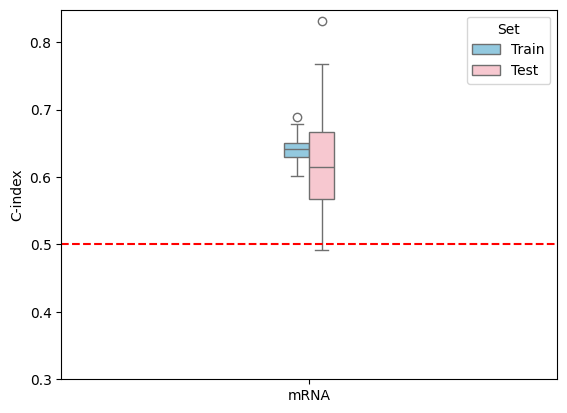

In [ ]:
# Handle mRNA data similarly
os_mrna = ge_data.join(sur_data, how='inner')

# Significant columns based on previous analysis
significant_cols = [
    "mRNA_LOC155006",
    "mRNA_RPP30",
    "mRNA_LMNA",
    "mRNA_MICALL2",
]

# Fit the model on significant columns
cphm = CoxPHFitter()
cphm.fit(os_mrna[["OS_OS", "OS_vital_status", *significant_cols]], event_col="OS_vital_status", duration_col="OS_OS")
cphm.check_assumptions(os_mrna[["OS_OS", "OS_vital_status", *significant_cols]])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

# Initialize lists for storing C-index values for mRNA data
mrna_c_index_train = []
mrna_c_index_test = []

# Iterate over the entire dataset for bootstrapping and validation
for i in range(train_data.shape[1]):
    train_sample = os_mrna[os_mrna.index.isin(train_data[i].values)].iloc[:, 1:]
    test_sample = os_mrna[os_mrna.index.isin(test_data[i].values)].iloc[:, 1:]

    # Fit the Cox Proportional Hazards model using the training data with Lasso regularization
    cphm = CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample[["OS_OS", "OS_vital_status", *significant_cols]], event_col="OS_vital_status", duration_col="OS_OS")

    # Calculate and store C-index for trained and tested data
    mrna_c_index_train.append(cphm.concordance_index_)
    mrna_c_index_test.append(concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

# Convert the lists of C-index values to NumPy arrays
mrna_c_index_train = np.array(mrna_c_index_train)
mrna_c_index_test = np.array(mrna_c_index_test)

# Create a DataFrame with the C-index values and set labels
stacked = np.hstack([mrna_c_index_train, mrna_c_index_test])
both_sets = np.vstack([stacked, ["Train"] * len(mrna_c_index_train) + ["Test"] * len(mrna_c_index_test)]).T
mrna_results_df = pd.DataFrame({
    "Feature": ["mRNA"] * len(both_sets),
    "C-index": both_sets[:, 0].astype(float),
    "Set": both_sets[:, 1]
})

# Plot the C-index values for mRNA data
sns.boxplot(mrna_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set", palette={"Train": "skyblue", "Test": "pink"})
plt.yticks(np.linspace(0.3, 0.8, 6), labels=np.linspace(0.3, 0.8, 6).round(1))
plt.axhline(0.5, linestyle='dashed', color='red')
plt.xticks([0], ["mRNA"])
plt.xlabel("")
plt.show()

### Clin + CNA ~ survival

### Clin + genex ~ *survival*

### CNA + genex ~ survuval

### CNA + genex + clin ~ survival